In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [422]:
# Load the labeled index data from csv
labeled_index_df = pd.read_csv("./data/merge_file.csv")

## Build the model

In [448]:
# Set up datasets
exclude_col = ['Date_modified','index','price','volume','date','3m_crash_label','crash_label','6m_crash_label']
X = labeled_index_df.drop(exclude_col, axis=1)
y = labeled_index_df['1m_crash_label']

feature_names = list(X.columns)

In [425]:
# Handle extreme value
X[~np.isfinite(X)] = np.finfo(np.float64).max
X = np.clip(X, -1e6, 1e6) 

# Handle NaN
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [426]:
# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [427]:
# Resampling
over_sampler = RandomOverSampler(sampling_strategy='auto')
under_sampler = RandomUnderSampler(sampling_strategy='auto')

X_train, y_train = over_sampler.fit_resample(X_train, y_train)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

In [428]:
# Hyperparameter Tuning
param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [429]:
# Train the model
model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
model.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

In [430]:
# Evaluate the model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9612456747404844
Confusion Matrix:
[[4163  126]
 [  42    4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4289
           1       0.03      0.09      0.05        46

    accuracy                           0.96      4335
   macro avg       0.51      0.53      0.51      4335
weighted avg       0.98      0.96      0.97      4335



Problem: low recall and f1 score for crash label 1

## Feature Importance

Feature: price_change, Importance: -7.822956443002503e-06
Feature: volume_change, Importance: -1.172191262901607e-05
Feature: volatility, Importance: -1.535559616037908e-07


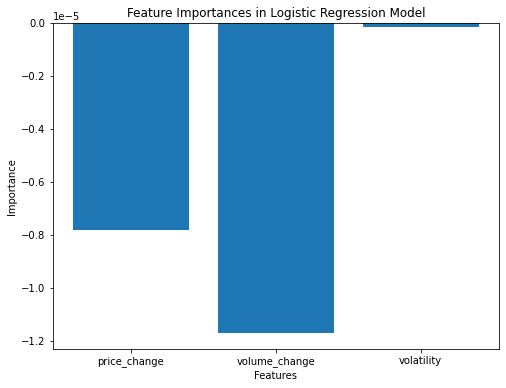

In [455]:
feature_importance = model.coef_[0]
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importances in Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## K-fold Validation

In [431]:
# Perform 10-fold cross-validation
scores = cross_val_score(model, X, y, cv=10)

# Print the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.98846863 0.98846863 0.98846863 0.98846863 0.98892478 0.98846331
 0.98846331 0.98846331 0.98846331 0.98846331]
Average cross-validation score: 0.99


## Prediction Result

In [432]:
y_prob = model.predict_proba(X_test)
crash_prob = y_prob[:, 1]
print(f"Crash Probability: {crash_prob.mean()}")

Crash Probability: 0.49304539628008565


## AUC-ROC

AUC-ROC Score: 0.4770494794570539


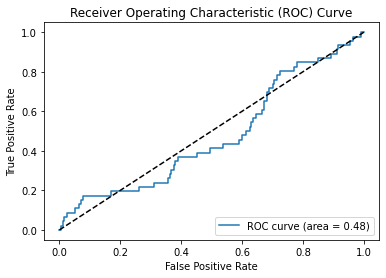

In [433]:
auc_roc = roc_auc_score(y_test, y_prob[:, 1])

print("AUC-ROC Score:", auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()